Git hub url: https://github.com/lynnolson/dtsa5511w3/tree/main

In [176]:
from collections import OrderedDict, Counter
import glob
import math
import os
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics  import accuracy_score, roc_auc_score
from skimage import io

from tqdm import tqdm
import wandb
import seaborn as sns
from IPython.display import Image

import matplotlib.pyplot as plt

# Histopathologic Cancer Detection

In this project we try to identify whether metastatic cancer is present in a histological slide. This is a binary classification task - 1 indicates cancer is present, 0 indicates that it's not.

We will use the data from the Kaggle task [Histopathologic Cancer Detection](https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview). There are 220,025 images available for training and 57,458 for testing.  Each image is 96x96 pixels with 3 channels.  In theory, we only have to look at the center 32x32 section of the image to detect cancer.

The train images are in TIFF image format and are located under the train directory.  A csv file is provided that gives the id for each training image and the corresponding label.  The test set, also in TIFF format, is under the test directory.  No labels are given.

The metric defined for this tasks is area under the ROC curve (AUC).

# EDA

Let's load the csv file which contains the id of each image file along with the label. 

In [2]:
full_train_df = pd.read_csv('train_labels.csv')

In [3]:
full_train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


The only feature we have is the id of the file containing an image which we will have to load.

We aren't missing any of the 220,025 ids or labels.

In [4]:
full_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


It looks like we have ~131K negative examples and ~89K positive ones.  This isn't really that much of an imbalance so we won't make any adjustments below based on the number of samples in each category.

In [5]:
n_neg, n_pos = full_train_df.label.value_counts().values

In [6]:
n_neg, n_pos

(130908, 89117)

[Text(0.5, 0, '')]

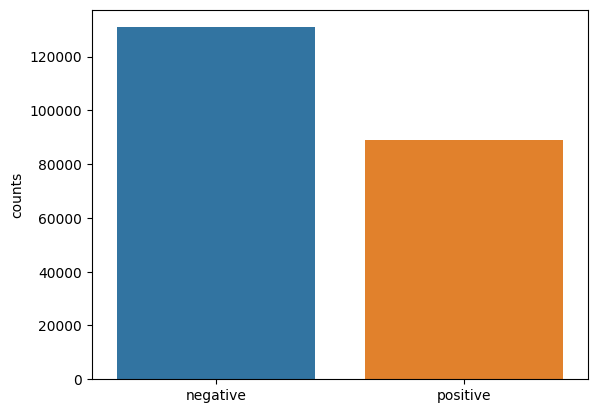

In [7]:
label_df = pd.DataFrame({'label': ['negative', 'positive'], 'counts': [n_neg, n_pos]})
chart = sns.barplot(data=label_df, x="label", y="counts")
chart.set(xlabel=None)

Let's load a few images.

In [164]:
negative_sample = full_train_df[full_train_df.label == 0].sample(4, random_state=42)
positive_sample = full_train_df[full_train_df.label == 1].sample(4, random_state=41)

In [165]:
negative_sample_images = [io.imread(os.path.join('train/', f"{id_}.tif")) for id_ in negative_sample.id.values]
positive_sample_images = [io.imread(os.path.join('train/', f"{id_}.tif")) for id_ in positive_sample.id.values]

Let's first take a look at a few negative (non-cancer) sample images.

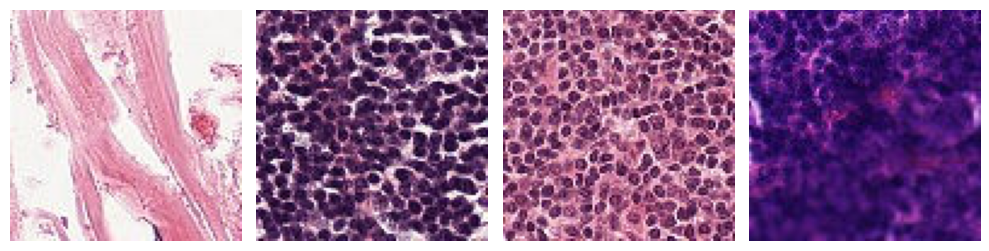

In [166]:
fig, axes = plt.subplots(1, 4, figsize=(10,4))
for ax, img in zip(axes, negative_sample_images):
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

We can zoom in on the center 32x32 pixels to see the patch our models will need to examine in order to detect the presence of cancer.

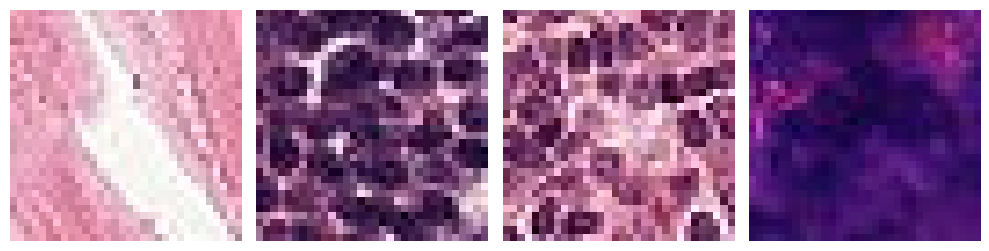

In [167]:
fig, axes = plt.subplots(1, 4, figsize=(10,4))
for ax, img in zip(axes, negative_sample_images):
    center = img[32:64, 32:64, :]
    ax.imshow(center)
    ax.axis('off')

plt.tight_layout()
plt.show()

Now let's take a look at a few positive (cancer) samples images.

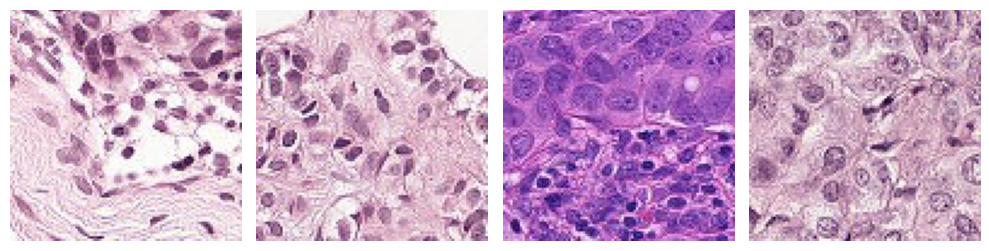

In [168]:
fig, axes = plt.subplots(1, 4, figsize=(10,4))
for ax, img in zip(axes, positive_sample_images):
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

We also zoom in on the center 32x32 pixels of these.

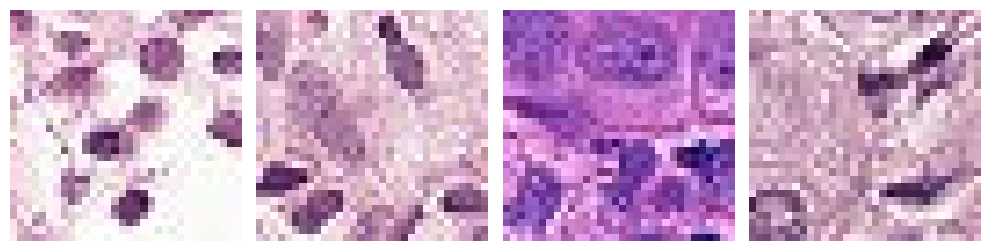

In [169]:
fig, axes = plt.subplots(1, 4, figsize=(10,4))
for ax, img in zip(axes, positive_sample_images):
    center = img[32:64, 32:64, :]
    ax.imshow(center)
    ax.axis('off')

plt.tight_layout()
plt.show()

The noncancerous slides DO look different than the cancerous ones.  The cytoplasma of the cancerous cells look enlarged - they demonstrate cellular atypia.

Also, as I look more closely at the 32x32 cropped images, I see that some of these abnormal cells DO GET CHOPPED OFF.  I wish I had noticed this earlier because the authors of the Kaggle project say the surrounding part of the image doesn't matter but that is not true.  

At any rate, we won't check for duplicates, assuming the Kaggle authors statement that there are no duplicates is true (though I probably should check that).  But we should make sure all of the images are of the same size.  To check, we will create dataloaders that normalize the images for training stability and convert them into tensors which we'll need for the models below.

In [43]:
batch_size = 32

In [44]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [45]:
class PathologyImageDataset(Dataset):
    """Histopathologic cancer dataset."""

    def __init__(self, image_df, root_dir, transform, keep_in_mem=False, crop=True):
        """
        Arguments:
            csv_file (string): Path to the csv file with labels.
            root_dir (string): Directory with all the images.
            transform (callable): Transform to be applied to each image (ex. normalize).
            keep_in_mem (bool, optional): Optionally load images into memory (need at least 4G but much faster)
            crop (bool, optional): Optionally crop the image to 32x32.  It turns out to be a bad idea to do so (discussed below.)
        """
        self.keep_in_mem = keep_in_mem
        self.image_df = image_df
        if self.keep_in_mem:
            self.images = []
            for image_id in tqdm(self.image_df.id):
                img_name = os.path.join(root_dir, f"{image_id}.tif")
                image = io.imread(img_name)
                self.images.append(image)
            self.labels = list(self.image_df.label)
        else:
            self.root_dir = root_dir

        self.transform = transform
        self.crop = crop
        self.img_size = 32 if crop else 96

    def __len__(self):
        return len(self.image_df)

    def __getitem__(self, idx):
        if self.keep_in_mem:
            image, label = self.images[idx], float(self.labels[idx])
        else:
            # Load from file
            img_name = os.path.join(self.root_dir, f"{self.image_df.iloc[idx, 0]}.tif")
            image = io.imread(img_name)
            label = self.image_df.iloc[idx, 1].astype('float')
        if self.crop:
            cropped_image = image[32:64, 32:64, :]
        else:
            cropped_image = image
        transformed_image = self.transform(cropped_image)
        return transformed_image, label

In [46]:
full_dataset = PathologyImageDataset(full_train_df, root_dir='train/', transform=transform, keep_in_mem=True, crop=False)
full_dataloader = torch.utils.data.DataLoader(full_dataset, batch_size=batch_size, shuffle=False, num_workers=32)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 220025/220025 [00:45<00:00, 4840.28it/s]


Let's check the image sizes.

In [47]:
sizes_ctr = Counter([inputs.shape[-2:] for inputs, _ in full_dataloader])

In [48]:
sizes_ctr

Counter({torch.Size([96, 96]): 6876})

Good - they are all 96x96 pixels.  Now we will separate our training set into two.  5000 images will be used for validation with the remaining 215,025 used for training.

In [49]:
train_df, dev_df = train_test_split(full_train_df, test_size=5000, random_state=42)

In [50]:
len(train_df), len(dev_df)

(215025, 5000)

Load the corresponding datasets for training and validation.

In [51]:
del full_dataset
del full_dataloader

Load a variant in which we crop the images to 32x32 pixels.

In [52]:
train_dataset = PathologyImageDataset(train_df, root_dir='train/', transform=transform, keep_in_mem=True)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=32)

dev_dataset = PathologyImageDataset(dev_df, root_dir='train/', transform=transform, keep_in_mem=True)
dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=batch_size, shuffle=False, num_workers=32)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 4945.99it/s]


We also load a variant that doesn't crop the images.

In [53]:
non_cropped_train_dataset = PathologyImageDataset(train_df, root_dir='train/', transform=transform, keep_in_mem=True, crop=False)
non_cropped_train_dataloader = torch.utils.data.DataLoader(non_cropped_train_dataset, batch_size=batch_size, shuffle=True, num_workers=32)

non_cropped_dev_dataset = PathologyImageDataset(dev_df, root_dir='train/', transform=transform, keep_in_mem=True, crop=False)
non_cropped_dev_dataloader = torch.utils.data.DataLoader(non_cropped_dev_dataset, batch_size=batch_size, shuffle=False, num_workers=32)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 4825.75it/s]


# Models

We will try several models, all based on convolutional networks.

The baseline model uses a traditional CNN, i.e. a model comprised of an *encoder* followed by a *classifier*.  The encoder contains one or more layers, each of which contains a convolution sublayer followd by pooling sublayer.  The classifier consists of one or more fully connected layers followed by an output layer.

This is a common model architecture to use for image classification tasks because they can capture local features, for example lines, along with more global features like objects. Furthermore, they can do so in a translationally invariant way, i.e. it does matter whether a feature is positioned one way or another.  A face, for example, is still a face if you flip it horizontally.

We will then do some hyperparameter searching to find a better model using variants of the traditional CNN architecture (number of layers, size of feature maps, etc.)

And finally we try ResNet-50, a convolutional neural network with many layers and *residual* connections between the input of each layer and the next to allow gradients to flow freely during backpropagation.

In [55]:
device = 'cuda:1'

We are not going to vary the loss function - given that this is a binary task let's use binary cross entropy.  This will be used across all models.

In [54]:
loss_fn = nn.BCEWithLogitsLoss()

## Baseline model

Define some functions for calculating the correct size of a convolutional output layer and input size for the fully connected layers.

In [56]:
def calc_conv_sz_out(size_in, p, k, s):
    return math.floor(((size_in + 2*p - k) / s) + 1)

def calc_fc_in_size(img_size, filter_sizes, conv_dims):
    filter_in_size = img_size
    for filter_size in filter_sizes:
        filter_out_size = calc_conv_sz_out(filter_in_size, 0, filter_size, 1)
        filter_out_size //= 2 # for max pool
        filter_in_size = filter_out_size
    return conv_dims[-1]*filter_out_size*filter_out_size

Also define a CNN class we can arbitrarily assign the number of layers, size of feature maps, and kernel (filter) sizes.

In [57]:
class CNN_Block(nn.Module):
    """
    Constituent convolution block of a CNN.
    """
    def __init__(self, in_dim, conv_dim, kernel_size, apply_bn=True):
        super(CNN_Block, self).__init__()

        self.apply_bn = apply_bn
        self.conv = nn.Conv2d(in_dim, conv_dim, kernel_size=kernel_size)
        nn.init.xavier_uniform_(self.conv.weight)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        if apply_bn:
            self.batch_norm = nn.BatchNorm2d(conv_dim)

    def forward(self, x):
        x = self.conv(x)
        if self.apply_bn:
            x = self.batch_norm(x)
        x = self.relu(x)
        x = self.pool(x)
        return x
    
class CNN_Model(nn.Module):
    """
    Traditional CNN - an encoder followed by a classifier. 
    :param img_size to calculate correct size of input to fully connected layer
    :param conv_dims list of feature map sizes; list size determines number of layers
    :param kernel_sizes list of kernel sizes; list size determines number of layers
    :param fc_dims list of number of neurons in each fully connected layer
    :param apply_bn (optional) apply batch normalization
    """
    def __init__(self, img_size, conv_dims, kernel_sizes, fc_dims, apply_bn=True):
        super(CNN_Model, self).__init__()

        # Encoder
        self.n_conv_layers = len(conv_dims)
        conv_layer_input_dims = [3] + conv_dims[:self.n_conv_layers-1]
        self.conv_layers = nn.Sequential(OrderedDict([(f"conv_layer{layer + 1}",
                                                       CNN_Block(conv_layer_input_dims[layer],
                                                                 conv_dims[layer],
                                                                 kernel_sizes[layer],
                                                                 apply_bn=apply_bn))
                                                      for layer in range(self.n_conv_layers)]))

        # Classifier
        self.n_fc_layers = len(fc_dims)
        encoder_out_dim, last_kernel_sz = conv_dims[-1], kernel_sizes[-1]
        fc1_in_dim = encoder_out_dim * (last_kernel_sz-1) * (last_kernel_sz-1)
        fc1_in_dim = calc_fc_in_size(img_size, kernel_sizes, conv_dims)
        fc_layer_input_dims = [fc1_in_dim] + fc_dims[:self.n_fc_layers-1]
        self.fc_layers = nn.Sequential(OrderedDict([(f"fc_layer{layer + 1}", nn.Linear(fc_layer_input_dims[layer], fc_dims[layer]))
                                                     for layer in range(self.n_fc_layers)]))
        self.out_layer = nn.Linear(fc_dims[-1], 1)

    def forward(self, x):
        # Run through encoder
        for conv_layer in self.conv_layers:
            x = conv_layer(x)

        # Run through classifier
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        # print(f"{x.shape}")
        for fc_layer in self.fc_layers:
            x = fc_layer(x)

        # Finally run through output layer
        return self.out_layer(x)

We also need to define some functions for the training process.

In [58]:
def validate(model, dev_dl):
    """
    Evaluate the loss on the validation set.
    """
    model.eval()
    n_examples = 0
    dev_loss = 0.
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dev_dl, 0):
            inputs = inputs.to(device)
            labels = labels.to(device)

            logits = model(inputs)
            dev_loss += loss_fn(logits.squeeze(-1), labels)
            n_examples += labels.shape[0]

    dev_loss = dev_loss.item() / n_examples
    
    return dev_loss

In [59]:
def calc_metrics(model, dev_dl):
    """
    Calculate accuracy and AUC.
    """
    model.eval()
    y = []
    yhat = []
    with torch.no_grad():
        for i, data in enumerate(dev_dl, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
        
            logits = model(inputs)
            preds = (torch.sigmoid(logits) > .5).to(torch.int32).squeeze().cpu().tolist()
            yhat.extend(preds)
            y.extend(labels.to(torch.int32).cpu().tolist())

    acc = accuracy_score(y, yhat)
    roc_auc = roc_auc_score(y, yhat)

    return acc, roc_auc

In [60]:
def train_model(model, lr, n_epochs, train_dl, dev_dl, batch_size=batch_size, optimizer=None,
                use_lr_decay=False, n_print_stats_per_epoch=10, log_wanda=False):
    """
    Train a model.
    """
    model = model.to(device)

    print_stats_time_period = math.floor((len(train_df)/batch_size)/n_print_stats_per_epoch)
    if optimizer is None:
        optimizer = optim.AdamW(params=model.parameters(), lr=lr)
    if use_lr_decay:
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

    start_time = time.time()
    n_steps = 0
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        model.train()
        running_loss = 0.0
        n_examples = 0
        for i, (inputs, labels) in enumerate(train_dl, 0):
            inputs = inputs.to(device)
            labels = labels.to(device)
    
            # zero the parameter gradients
            optimizer.zero_grad()
    
            # forward + backward + optimize
            logits = model(inputs)
            loss = loss_fn(logits.squeeze(-1), labels)
            loss.backward()
            optimizer.step()
    
            # Print statistics
            running_loss += loss.item()
            n_examples += len(labels)
            if i % print_stats_time_period == print_stats_time_period-1:    # print every print_stats_time_delta mini-batches
                train_loss = running_loss / n_examples
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {train_loss:.3f}')

                running_loss = 0.0
                n_examples = 0
                
                if log_wanda:
                    wandb.log({"step": n_steps})
                    wandb.log({"train_loss": train_loss})
                    # wandb.log({"dev_loss": dev_loss})
            n_steps += 1
            
        # Get validation loss and calc metrics
        dev_loss = validate(model, dev_dl)
        acc, roc_auc = calc_metrics(model, dev_dl)
        print(f'[{epoch + 1}, {i + 1:5d}] dev loss: {dev_loss:.3f}, acc={roc_auc}')
        
        if log_wanda:
            wandb.log({"dev_loss": dev_loss})
            wandb.log({"roc_auc": roc_auc})
        if use_lr_decay:
            scheduler.step()

    print("Training took {:.1f} seconds".format(time.time() - start_time))

Start with a baseline of 2-layer convolutional sublayers and 2 fully connected layers.  Train with Adam and learning rate = 0.0001.

I use [Weights and Biases](https://wandb.ai/site) to log experiments, including training and dev loss along with metrics like accuracy and AUC.

In [68]:
log_wanda=True

In [69]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lyol9217 (codegreen). Use `wandb login --relogin` to force relogin


True

In [70]:
wandb.init(name='bad_baseline_model', 
           project='dtsa5511_week3',
           notes='run baseline cnn lr=0.0001, cropped image')

In [71]:
conv_dims = [8, 16]
kernel_sizes = [3, 3]
fc_dims = [256, 64]
cnn_baseline_model = CNN_Model(train_dataset.img_size, conv_dims, kernel_sizes, fc_dims)
train_model(cnn_baseline_model, 0.001, 3, train_dataloader, dev_dataloader, log_wanda=log_wanda)

[1,   671] loss: 0.016
[1,  1342] loss: 0.015
[1,  2013] loss: 0.015
[1,  2684] loss: 0.015
[1,  3355] loss: 0.015
[1,  4026] loss: 0.014
[1,  4697] loss: 0.014
[1,  5368] loss: 0.014
[1,  6039] loss: 0.014
[1,  6710] loss: 0.014
[1,  6720] dev loss: 0.013, acc=0.810256497879369
[2,   671] loss: 0.014
[2,  1342] loss: 0.014
[2,  2013] loss: 0.014
[2,  2684] loss: 0.014
[2,  3355] loss: 0.014
[2,  4026] loss: 0.014
[2,  4697] loss: 0.014
[2,  5368] loss: 0.014
[2,  6039] loss: 0.014
[2,  6710] loss: 0.014
[2,  6720] dev loss: 0.013, acc=0.8100222638453963
[3,   671] loss: 0.014
[3,  1342] loss: 0.014
[3,  2013] loss: 0.014
[3,  2684] loss: 0.014
[3,  3355] loss: 0.014
[3,  4026] loss: 0.014
[3,  4697] loss: 0.014
[3,  5368] loss: 0.014
[3,  6039] loss: 0.013
[3,  6710] loss: 0.014
[3,  6720] dev loss: 0.013, acc=0.806344026426642
Training took 102.7 seconds


In [37]:
torch.save(cnn_baseline_model, 'cnn_baseline_model.pth')

In [38]:
acc, roc_auc = calc_metrics(cnn_baseline_model, dev_dataloader)
tag = "cnn_baseline_model"
print(f"{tag} model: acc = {acc:.3f}, auc={roc_auc:.3f}")

baseline_cnn_model model: acc = 0.830, auc=0.818


The baseline AUC isn't terrible - clearly the model learned something given that the loss does drop to 0.014 and the AUC is greater than 80%.  But when I looked at the training loss over time, it appeared to be too high and flat.

NOTE: I ran this for 20 epochs and the loss curve flattens at ~0.013.  It just takes ~10 minutes to train for 20 epochs.  3 epochs is enough to show the curve flattening.

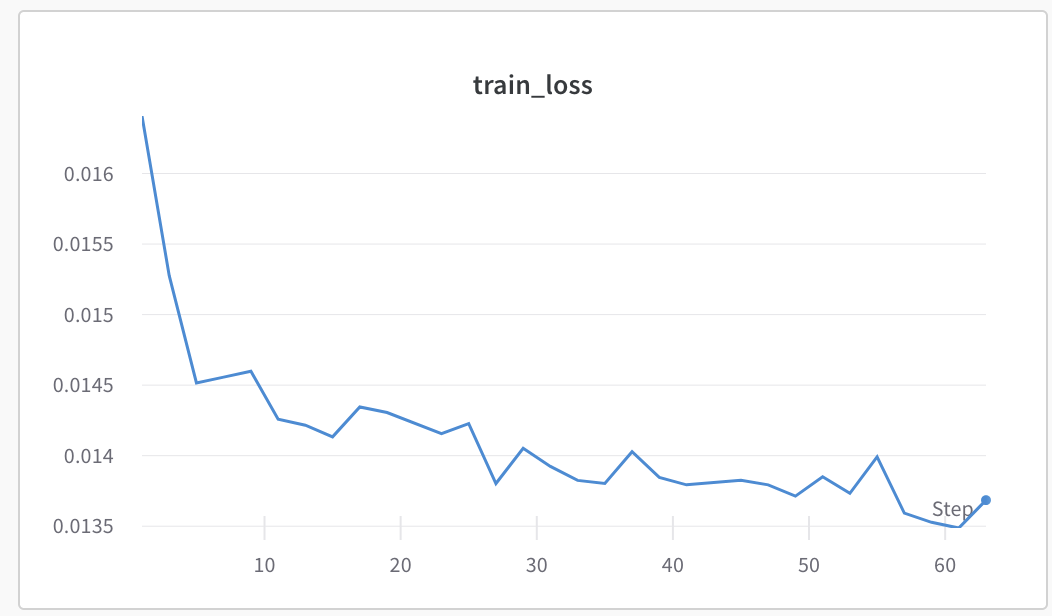

In [72]:
Image(filename = "img/baseline_wb_train_loss.png", width=600, height=400)

So I lowered the learning rate to 0.0005.

In [73]:
wandb.init(name='bad_baseline_lower_lr_model',
           project='dtsa5511_week3',
           notes='run baseline cnn lr=0.00005, cropped')

dev_loss,█▄▁
roc_auc,██▁
step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▅▃▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
dev_loss,0.01276
roc_auc,0.80634
step,20149
train_loss,0.01368


In [74]:
cnn_baseline_lower_lr_model = CNN_Model(train_dataset.img_size, conv_dims, kernel_sizes, fc_dims)
train_model(cnn_baseline_lower_lr_model, 0.00005, 3, train_dataloader, dev_dataloader, log_wanda=log_wanda)

[1,   671] loss: 0.017
[1,  1342] loss: 0.017
[1,  2013] loss: 0.017
[1,  2684] loss: 0.016
[1,  3355] loss: 0.016
[1,  4026] loss: 0.016
[1,  4697] loss: 0.016
[1,  5368] loss: 0.016
[1,  6039] loss: 0.015
[1,  6710] loss: 0.015
[1,  6720] dev loss: 0.015, acc=0.7773734070385336
[2,   671] loss: 0.015
[2,  1342] loss: 0.015
[2,  2013] loss: 0.015
[2,  2684] loss: 0.015
[2,  3355] loss: 0.015
[2,  4026] loss: 0.015
[2,  4697] loss: 0.015
[2,  5368] loss: 0.015
[2,  6039] loss: 0.015
[2,  6710] loss: 0.015
[2,  6720] dev loss: 0.014, acc=0.7884446146825258
[3,   671] loss: 0.015
[3,  1342] loss: 0.015
[3,  2013] loss: 0.015
[3,  2684] loss: 0.015
[3,  3355] loss: 0.015
[3,  4026] loss: 0.015
[3,  4697] loss: 0.015
[3,  5368] loss: 0.015
[3,  6039] loss: 0.015
[3,  6710] loss: 0.015
[3,  6720] dev loss: 0.014, acc=0.7930487566767898
Training took 102.7 seconds


In [75]:
torch.save(cnn_baseline_lower_lr_model, 'cnn_baseline_lower_lr_model.pth')

In [76]:
acc, roc_auc = calc_metrics(cnn_baseline_lower_lr_model, dev_dataloader)
tag = "cnn_baseline_lower_lr_model"
print(f"{tag} model: acc = {acc:.3f}, auc={roc_auc:.3f}")

cnn_baseline_lower_lr_model model: acc = 0.807, auc=0.793


This didn't help - the AUC is worse.  The training loss (and dev loss) just plateaued.  And looking at the validation AUC not improving indicates theres's a problem with something I am doing.

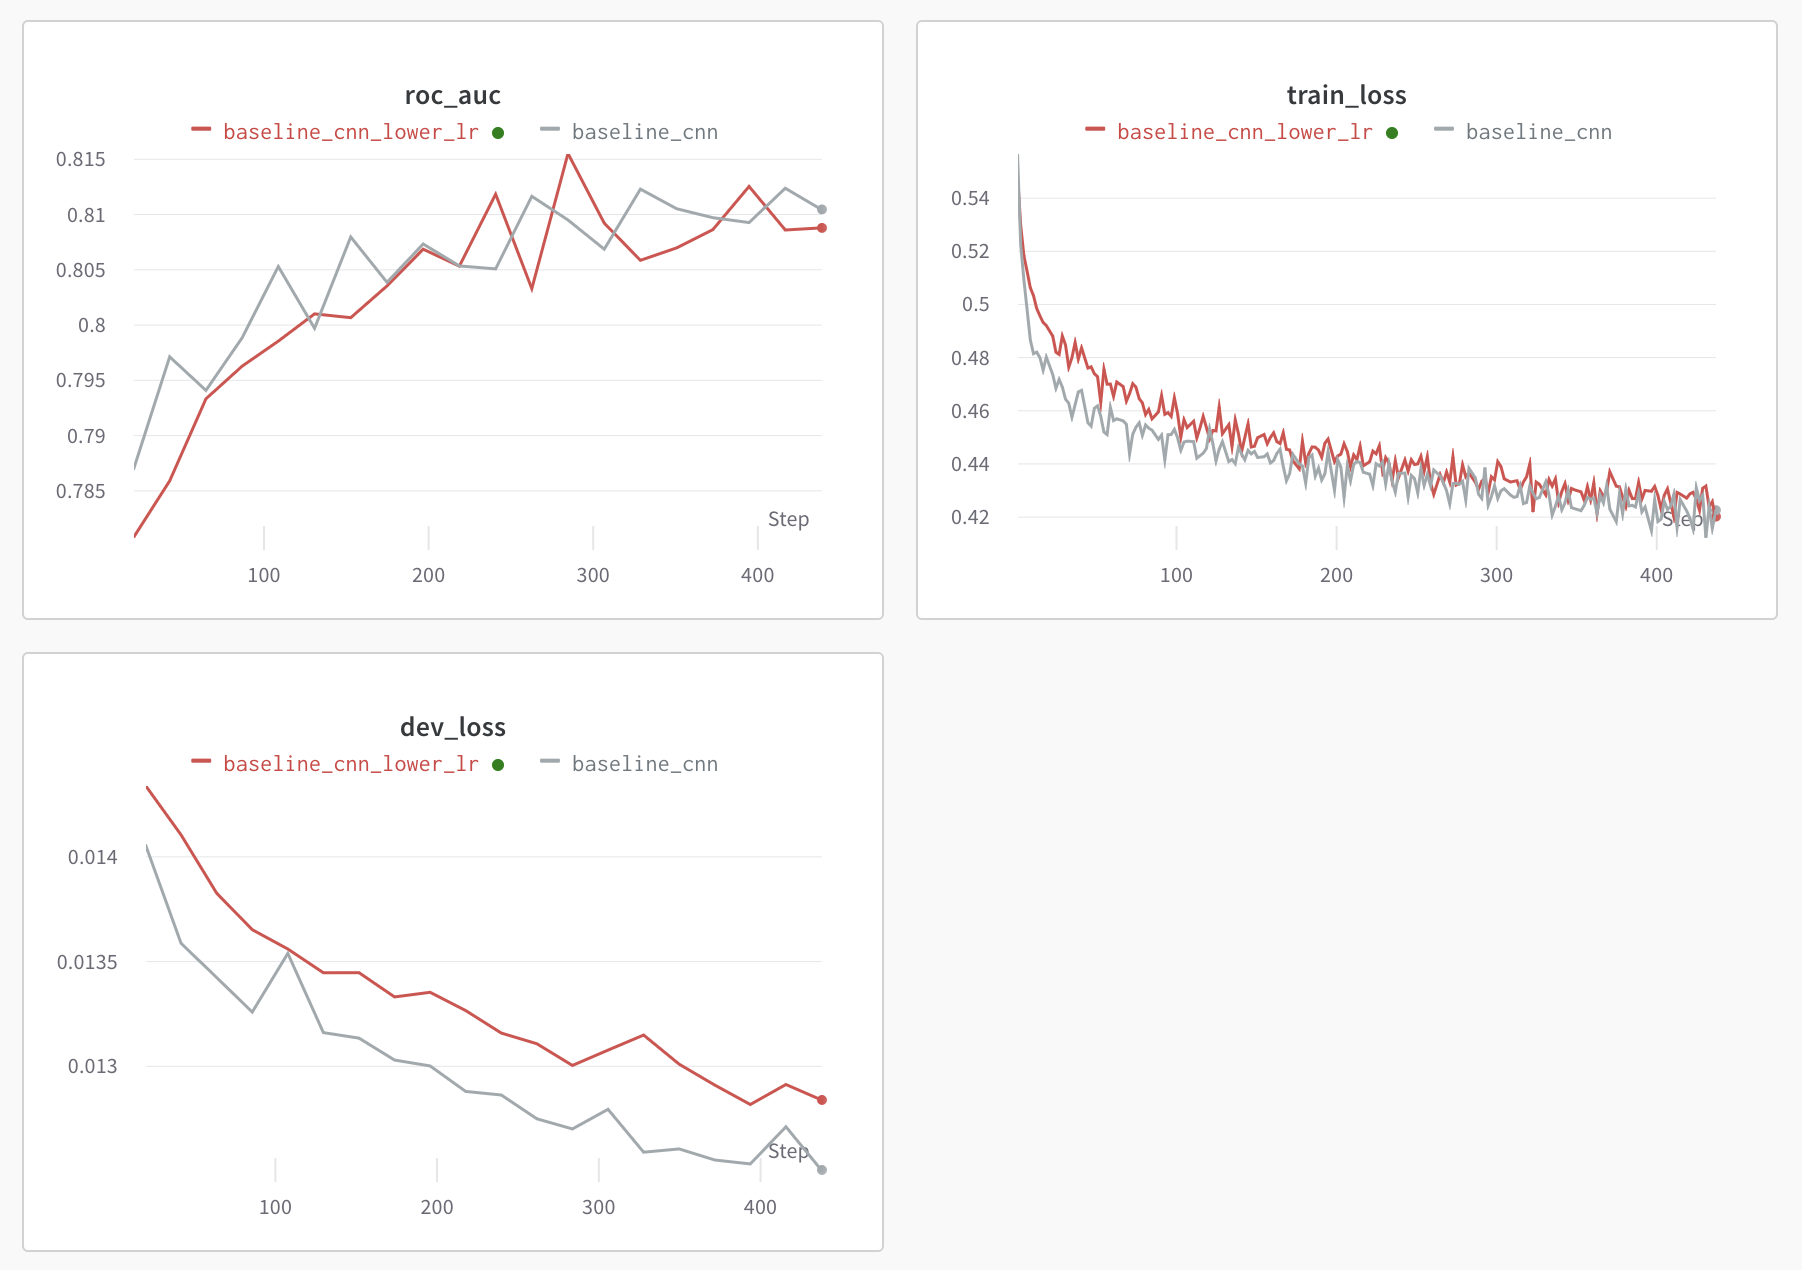

In [54]:
Image(filename = "img/bad_baselines_wb_all_plots.png", width=800, height=400)

It turns out that I need to look at the whole image, just the 32x32 center, even if that is all that is needed to detect cancer.  The issue is that I am not capturing enough 'edge' features which help diagnose cancer.

So I went back and retrained the baseline model with the dataset in which the images were NOT cropped to 32x32 pixels.

In [77]:
wandb.init(name='ok_baseline_cnn_model', 
           project='dtsa5511_week3',
           notes='run fixed baseline')

dev_loss,█▃▁
roc_auc,▁▆█
step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▆▆▅▄▄▃▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁
dev_loss,0.01384
roc_auc,0.79305
step,20149
train_loss,0.01469


In [81]:
log_wanda = False

In [85]:
cnn_fixed_baseline_model = CNN_Model(non_cropped_train_dataset.img_size, conv_dims, kernel_sizes, fc_dims)
train_model(cnn_fixed_baseline_model, 0.0001, 3, non_cropped_train_dataloader, non_cropped_dev_dataloader, log_wanda=log_wanda)

[1,   671] loss: 0.016
[1,  1342] loss: 0.015
[1,  2013] loss: 0.014
[1,  2684] loss: 0.014
[1,  3355] loss: 0.014
[1,  4026] loss: 0.013
[1,  4697] loss: 0.014
[1,  5368] loss: 0.013
[1,  6039] loss: 0.013
[1,  6710] loss: 0.013
[1,  6720] dev loss: 0.013, acc=0.8267907332902134
[2,   671] loss: 0.013
[2,  1342] loss: 0.013
[2,  2013] loss: 0.013
[2,  2684] loss: 0.013
[2,  3355] loss: 0.013
[2,  4026] loss: 0.012
[2,  4697] loss: 0.012
[2,  5368] loss: 0.012
[2,  6039] loss: 0.012
[2,  6710] loss: 0.012
[2,  6720] dev loss: 0.011, acc=0.838433259640298
[3,   671] loss: 0.012
[3,  1342] loss: 0.012
[3,  2013] loss: 0.012
[3,  2684] loss: 0.012
[3,  3355] loss: 0.012
[3,  4026] loss: 0.012
[3,  4697] loss: 0.012
[3,  5368] loss: 0.012
[3,  6039] loss: 0.012
[3,  6710] loss: 0.012
[3,  6720] dev loss: 0.011, acc=0.8423340359801392
Training took 114.8 seconds


In [86]:
torch.save(cnn_fixed_baseline_model, 'cnn_fixed_baseline_model.pth')

In [87]:
acc, roc_auc = calc_metrics(cnn_fixed_baseline_model, non_cropped_dev_dataloader)
tag = "cnn_fixed_baseline_model"
print(f"{tag} model: acc = {acc:.3f}, auc={roc_auc:.3f}")

cnn_fixed_baseline_model model: acc = 0.844, auc=0.842


Now the loss is at least going down and the accuracy has improved quite a bit.  If I keep training this for more epochs, the loss does go down slowly but now the problem is model bias.  The training loss starts low even after one epoch, indicating that perhaps our model is too simple.

## Hyperparameter Search

We have a baseline CNN that has a dev AUC of ~84%.  Let's conduct a hyperparameter search to find a model and training profile that give us better results.

We will just do this manually, gradually adding complexity, though it would be better to use a tool like Weights and Biases to do this for us.

Let's start by increasing the number of convolutional layers to 3.

In [89]:
conv_dims = [8, 16, 32]
kernel_sizes = [3, 3, 3]
fc_dims = [256, 64]
cnn_3_layer_model = CNN_Model(non_cropped_train_dataset.img_size, conv_dims, kernel_sizes, fc_dims)
train_model(cnn_3_layer_model, 0.0001, 3, non_cropped_train_dataloader, non_cropped_dev_dataloader, log_wanda=False)

[1,   671] loss: 0.015
[1,  1342] loss: 0.014
[1,  2013] loss: 0.013
[1,  2684] loss: 0.013
[1,  3355] loss: 0.013
[1,  4026] loss: 0.013
[1,  4697] loss: 0.013
[1,  5368] loss: 0.013
[1,  6039] loss: 0.013
[1,  6710] loss: 0.012
[1,  6720] dev loss: 0.012, acc=0.8218028920604117
[2,   671] loss: 0.012
[2,  1342] loss: 0.012
[2,  2013] loss: 0.012
[2,  2684] loss: 0.012
[2,  3355] loss: 0.012
[2,  4026] loss: 0.012
[2,  4697] loss: 0.012
[2,  5368] loss: 0.012
[2,  6039] loss: 0.012
[2,  6710] loss: 0.012
[2,  6720] dev loss: 0.011, acc=0.8489819196872544
[3,   671] loss: 0.012
[3,  1342] loss: 0.011
[3,  2013] loss: 0.011
[3,  2684] loss: 0.012
[3,  3355] loss: 0.011
[3,  4026] loss: 0.012
[3,  4697] loss: 0.011
[3,  5368] loss: 0.011
[3,  6039] loss: 0.011
[3,  6710] loss: 0.011
[3,  6720] dev loss: 0.010, acc=0.861820084705795
Training took 180.4 seconds


In [91]:
torch.save(cnn_3_layer_model, 'cnn_3_layer_model.pth')

In [90]:
acc, roc_auc = calc_metrics(cnn_3_layer_model, non_cropped_dev_dataloader)
tag = "cnn_3_layer_model"
print(f"{tag} model: acc = {acc:.3f}, auc={roc_auc:.3f}")

cnn_3_layer_model model: acc = 0.869, auc=0.862


More complexity increases the capacity of the model leading to better results. The dev loss was still going down and the accuracy was increasing so clearly the model wasn't overtraining.

Let's increase our model capacity by adding yet another layer, each with a larger set of neurons and larger filter sizes.

In [92]:
conv_dims = [16, 32, 64, 128]
kernel_sizes = [5, 5, 3, 3]
fc_dims = [256, 64]
cnn_4_layer_model = CNN_Model(non_cropped_train_dataset.img_size, conv_dims, kernel_sizes, fc_dims)
train_model(cnn_4_layer_model, 0.0001, 3, non_cropped_train_dataloader, non_cropped_dev_dataloader, log_wanda=False)

[1,   671] loss: 0.015
[1,  1342] loss: 0.013
[1,  2013] loss: 0.013
[1,  2684] loss: 0.013
[1,  3355] loss: 0.012
[1,  4026] loss: 0.012
[1,  4697] loss: 0.012
[1,  5368] loss: 0.011
[1,  6039] loss: 0.011
[1,  6710] loss: 0.011
[1,  6720] dev loss: 0.010, acc=0.8656547546274078
[2,   671] loss: 0.011
[2,  1342] loss: 0.010
[2,  2013] loss: 0.010
[2,  2684] loss: 0.010
[2,  3355] loss: 0.010
[2,  4026] loss: 0.010
[2,  4697] loss: 0.010
[2,  5368] loss: 0.010
[2,  6039] loss: 0.010
[2,  6710] loss: 0.010
[2,  6720] dev loss: 0.009, acc=0.8866249214727083
[3,   671] loss: 0.009
[3,  1342] loss: 0.009
[3,  2013] loss: 0.009
[3,  2684] loss: 0.009
[3,  3355] loss: 0.009
[3,  4026] loss: 0.009
[3,  4697] loss: 0.009
[3,  5368] loss: 0.009
[3,  6039] loss: 0.009
[3,  6710] loss: 0.009
[3,  6720] dev loss: 0.008, acc=0.8909226680981706
Training took 132.7 seconds


In [94]:
torch.save(cnn_4_layer_model, 'cnn_4_layer_model.pth')

In [93]:
acc, roc_auc = calc_metrics(cnn_4_layer_model, non_cropped_dev_dataloader)
tag = "cnn_4_layer_model"
print(f"{tag} model: acc = {acc:.3f}, auc={roc_auc:.3f}")

cnn_4_layer_model model: acc = 0.899, auc=0.891


Can we get the dev AUC over 90 percent?  Let's try by training for a few more epochs.

In [96]:
# We've already trained for 3, add 2 to make it 5.
train_model(cnn_4_layer_model, 0.0001, 2, non_cropped_train_dataloader, non_cropped_dev_dataloader, log_wanda=False)

[1,   671] loss: 0.009
[1,  1342] loss: 0.008
[1,  2013] loss: 0.008
[1,  2684] loss: 0.008
[1,  3355] loss: 0.008
[1,  4026] loss: 0.008
[1,  4697] loss: 0.008
[1,  5368] loss: 0.008
[1,  6039] loss: 0.008
[1,  6710] loss: 0.008
[1,  6720] dev loss: 0.008, acc=0.9022162487751234
[2,   671] loss: 0.008
[2,  1342] loss: 0.008
[2,  2013] loss: 0.008
[2,  2684] loss: 0.008
[2,  3355] loss: 0.008
[2,  4026] loss: 0.008
[2,  4697] loss: 0.008
[2,  5368] loss: 0.008
[2,  6039] loss: 0.008
[2,  6710] loss: 0.008
[2,  6720] dev loss: 0.007, acc=0.9088217480660349
Training took 88.5 seconds


In [97]:
acc, roc_auc = calc_metrics(cnn_4_layer_model, non_cropped_dev_dataloader)
tag = "cnn_4_layer_5_epochs_model"
print(f"{tag} model: acc = {acc:.3f}, auc={roc_auc:.3f}")

cnn_4_layer_5_epochs_model model: acc = 0.916, auc=0.909


We are finally have AUC > 90%.  More feature maps seems to really help, so let's drop back to the 3-layer model, increase the number of feature maps, and train for much longer (20 epochs.)

In [100]:
conv_dims = [32, 64, 128]
kernel_sizes = [5, 3, 3]
cnn_3_layer_double_fmaps_model = CNN_Model(non_cropped_dev_dataset.img_size, conv_dims, kernel_sizes, fc_dims)
train_model(cnn_3_layer_double_fmaps_model, 0.0001, 20, non_cropped_train_dataloader, non_cropped_dev_dataloader, log_wanda=False)

[1,   671] loss: 0.014
[1,  1342] loss: 0.013
[1,  2013] loss: 0.012
[1,  2684] loss: 0.012
[1,  3355] loss: 0.012
[1,  4026] loss: 0.012
[1,  4697] loss: 0.012
[1,  5368] loss: 0.011
[1,  6039] loss: 0.012
[1,  6710] loss: 0.011
[1,  6720] dev loss: 0.011, acc=0.8639534889507726
[2,   671] loss: 0.011
[2,  1342] loss: 0.011
[2,  2013] loss: 0.011
[2,  2684] loss: 0.011
[2,  3355] loss: 0.011
[2,  4026] loss: 0.010
[2,  4697] loss: 0.010
[2,  5368] loss: 0.010
[2,  6039] loss: 0.010
[2,  6710] loss: 0.010
[2,  6720] dev loss: 0.009, acc=0.8541691584445599
[3,   671] loss: 0.010
[3,  1342] loss: 0.010
[3,  2013] loss: 0.010
[3,  2684] loss: 0.010
[3,  3355] loss: 0.010
[3,  4026] loss: 0.010
[3,  4697] loss: 0.009
[3,  5368] loss: 0.009
[3,  6039] loss: 0.009
[3,  6710] loss: 0.009
[3,  6720] dev loss: 0.009, acc=0.8826282617960143
[4,   671] loss: 0.009
[4,  1342] loss: 0.009
[4,  2013] loss: 0.009
[4,  2684] loss: 0.009
[4,  3355] loss: 0.009
[4,  4026] loss: 0.009
[4,  4697] loss: 0.

In [101]:
torch.save(cnn_3_layer_double_fmaps_model, 'cnn_3_layer_double_fmaps_model.pth')

In [102]:
acc, roc_auc = calc_metrics(cnn_3_layer_double_fmaps_model, non_cropped_dev_dataloader)
tag = "cnn_3_layer_double_fmaps_model"
print(f"{tag} model: acc = {acc:.3f}, auc={roc_auc:.3f}")

cnn_3_layer_double_fmaps_model model: acc = 0.924, auc=0.928


We could keep making adjustments but for this assignment this is sufficient.

## Resnet

Can we do better with on the dev set with a much more sophisticated model?  Let's try to use the pretrained model of ResNet with 50 layers.

In [109]:
resnet50_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
resnet50_model = resnet50_model.to(device)

Using cache found in /home/lynn/.cache/torch/hub/pytorch_vision_v0.10.0


We have to modify the final layer since ResNet-50 was trained on ImageNet which has 1000 classes.

In [110]:
num_ftrs = resnet50_model.fc.in_features
resnet50_model.fc = nn.Linear(num_ftrs, 1, device=device)

ResNet was trained with SGD, so let's use that as our optimizer.

In [114]:
optimizer = optim.SGD(resnet50_model.parameters(), lr=0.0001, momentum=0.9)

Fine tune for 10 epochs.

In [115]:
train_model(resnet50_model, 0.0001, 10, non_cropped_train_dataloader, non_cropped_dev_dataloader, optimizer=optimizer, log_wanda=False)

[1,   671] loss: 0.015
[1,  1342] loss: 0.011
[1,  2013] loss: 0.010
[1,  2684] loss: 0.009
[1,  3355] loss: 0.008
[1,  4026] loss: 0.008
[1,  4697] loss: 0.007
[1,  5368] loss: 0.007
[1,  6039] loss: 0.007
[1,  6710] loss: 0.007
[1,  6720] dev loss: 0.006, acc=0.9241003762508587
[2,   671] loss: 0.006
[2,  1342] loss: 0.006
[2,  2013] loss: 0.006
[2,  2684] loss: 0.006
[2,  3355] loss: 0.006
[2,  4026] loss: 0.006
[2,  4697] loss: 0.006
[2,  5368] loss: 0.006
[2,  6039] loss: 0.006
[2,  6710] loss: 0.005
[2,  6720] dev loss: 0.004, acc=0.9425823870936383
[3,   671] loss: 0.005
[3,  1342] loss: 0.005
[3,  2013] loss: 0.005
[3,  2684] loss: 0.005
[3,  3355] loss: 0.005
[3,  4026] loss: 0.005
[3,  4697] loss: 0.005
[3,  5368] loss: 0.005
[3,  6039] loss: 0.004
[3,  6710] loss: 0.005
[3,  6720] dev loss: 0.004, acc=0.9464049471820501
[4,   671] loss: 0.004
[4,  1342] loss: 0.004
[4,  2013] loss: 0.004
[4,  2684] loss: 0.004
[4,  3355] loss: 0.004
[4,  4026] loss: 0.004
[4,  4697] loss: 0.

In [140]:
torch.save(resnet50_model, 'resnet50_model.pth')

In [116]:
acc, roc_auc = calc_metrics(resnet50_model, non_cropped_dev_dataloader)
tag = "resnet50_model"
print(f"{tag} model: acc = {acc:.3f}, auc={roc_auc:.3f}")

resnet50_model model: acc = 0.965, auc=0.962


Yes, that's better but also took a lot longer to train.  But it's really helpful to employ residual connections in any kind of network since they allow gradients to flow backwards thus allowing parameters in lower layers to change.

I trained it for another 10 epochs - this turned out to be the best scoring model for the public dataset.

In [142]:
train_model(resnet50_model, 0.0001, 10, non_cropped_train_dataloader, non_cropped_dev_dataloader, optimizer=optimizer, log_wanda=False)

[1,   671] loss: 0.001
[1,  1342] loss: 0.001
[1,  2013] loss: 0.001
[1,  2684] loss: 0.001
[1,  3355] loss: 0.001
[1,  4026] loss: 0.001
[1,  4697] loss: 0.001
[1,  5368] loss: 0.001
[1,  6039] loss: 0.001
[1,  6710] loss: 0.001
[1,  6720] dev loss: 0.004, acc=0.9635647467162031
[2,   671] loss: 0.001
[2,  1342] loss: 0.001
[2,  2013] loss: 0.001
[2,  2684] loss: 0.001
[2,  3355] loss: 0.001
[2,  4026] loss: 0.001
[2,  4697] loss: 0.001
[2,  5368] loss: 0.001
[2,  6039] loss: 0.001
[2,  6710] loss: 0.001
[2,  6720] dev loss: 0.004, acc=0.962314613798342
[3,   671] loss: 0.001
[3,  1342] loss: 0.001
[3,  2013] loss: 0.001
[3,  2684] loss: 0.001
[3,  3355] loss: 0.001
[3,  4026] loss: 0.001
[3,  4697] loss: 0.001
[3,  5368] loss: 0.001
[3,  6039] loss: 0.001
[3,  6710] loss: 0.001
[3,  6720] dev loss: 0.004, acc=0.9647548281324365
[4,   671] loss: 0.001
[4,  1342] loss: 0.001
[4,  2013] loss: 0.001
[4,  2684] loss: 0.001
[4,  3355] loss: 0.001
[4,  4026] loss: 0.001
[4,  4697] loss: 0.0

In [143]:
torch.save(resnet50_model, 'resnet50_20_epoch_model.pth')

In [144]:
acc, roc_auc = calc_metrics(resnet50_model, non_cropped_dev_dataloader)
tag = "resnet50_20_epoch_model"
print(f"{tag} model: acc = {acc:.3f}, auc={roc_auc:.3f}")

resnet50_20_epoch_model model: acc = 0.966, auc=0.964


# Results and Analysis

Let's run some of these models on the test set and submit the results to Kaggle

In [117]:
test_ids = [fn.split('/')[-1].replace('.tif', '') for fn in glob.glob('test/*.tif')]

It looks like we have 57,458 images in the test set.

In [118]:
len(test_ids)

57458

Let's create a pandas dataframe for the test set.  Initially, all of the labels will be zero.

In [120]:
test_df = pd.DataFrame(data={'id': test_ids, 'label': [0]*len(test_ids)})

Load the images without doing any cropping like we did for the better models.

In [122]:
test_dataset = PathologyImageDataset(test_df, root_dir='test/', transform=transform, keep_in_mem=True, crop=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=32)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57458/57458 [00:12<00:00, 4712.52it/s]


And load a cropped version just to see what results we get on the test set.

In [123]:
test_cropped_dataset = PathologyImageDataset(test_df, root_dir='test/', transform=transform, keep_in_mem=True, crop=True)
test_cropped_dataloader = torch.utils.data.DataLoader(test_cropped_dataset, batch_size=batch_size, shuffle=False, num_workers=32)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 57458/57458 [00:11<00:00, 4798.64it/s]


We will generate predictions using the models we generated above and update a copy of the test dataframe.

In [124]:
def predict(model, test_dl):
    """
    Generate predictions on the test dataset.
    """
    model.eval()
    yhat = []
    with torch.no_grad():
        for i, data in enumerate(test_dl, 0):
            inputs, _ = data
            inputs = inputs.to(device)
        
            logits = model(inputs)
            preds = (torch.sigmoid(logits) > .5).to(torch.int32).squeeze().cpu().tolist()
            yhat.extend(preds)

    return yhat

In [127]:
cnn_baseline_model = torch.load('cnn_baseline_model.pth')
cnn_baseline_model_preds = predict(cnn_baseline_model, test_cropped_dataloader)
cnn_baseline_model_df = pd.DataFrame(data={'id': test_ids, 'label': cnn_baseline_model_preds})
cnn_baseline_model_df.to_csv('cnn_baseline_model_submission.csv', index=False)

In [135]:
cnn_fixed_baseline_model = torch.load('cnn_fixed_baseline_model.pth')
cnn_fixed_baseline_model_preds = predict(cnn_fixed_baseline_model, test_dataloader)
cnn_fixed_baseline_model_df = pd.DataFrame(data={'id': test_ids, 'label': cnn_fixed_baseline_model_preds})
cnn_fixed_baseline_model_df.to_csv('cnn_fixed_baseline_model_submission.csv', index=False)

In [136]:
cnn_3_layer_model = torch.load('cnn_3_layer_model.pth')
cnn_3_layer_model_preds = predict(cnn_3_layer_model, test_dataloader)
cnn_3_layer_model_df = pd.DataFrame(data={'id': test_ids, 'label': cnn_3_layer_model_preds})
cnn_3_layer_model_df.to_csv('cnn_3_layer_model_submission.csv', index=False)

In [137]:
cnn_4_layer_model = torch.load('cnn_4_layer_model.pth')
cnn_4_layer_model_preds = predict(cnn_4_layer_model, test_dataloader)
cnn_4_layer_model_df = pd.DataFrame(data={'id': test_ids, 'label': cnn_4_layer_model_preds})
cnn_4_layer_model_df.to_csv('cnn_4_layer_model_submission.csv', index=False)

In [139]:
cnn_3_layer_double_fmaps_model = torch.load('cnn_3_layer_double_fmaps_model.pth')
cnn_3_layer_double_fmaps_model_preds = predict(cnn_3_layer_double_fmaps_model, test_dataloader)
cnn_3_layer_double_fmaps_model_df = pd.DataFrame(data={'id': test_ids, 'label': cnn_3_layer_double_fmaps_model_preds})
cnn_3_layer_double_fmaps_model_df.to_csv('cnn_3_layer_double_fmaps_model_sumbmission.csv', index=False)

In [141]:
resnet50_model = torch.load('resnet50_model.pth')
resnet50_model_preds = predict(resnet50_model, test_dataloader)
resnet50_model_df = pd.DataFrame(data={'id': test_ids, 'label': resnet50_model_preds})
resnet50_model_df.to_csv('resnet50_model_sumbmission.csv', index=False)

In [147]:
resnet50_20_epoch_model = torch.load('resnet50_20_epoch_model.pth')
resnet50_20_epoch_model_preds = predict(resnet50_20_epoch_model, test_dataloader)
resnet50_20_epoch_model_df = pd.DataFrame(data={'id': test_ids, 'label': resnet50_20_epoch_model_preds})
resnet50_20_epoch_model_df.to_csv('resnet50_20_epoch_model_sumbmission.csv', index=False)

The test results from Kaggle are shown in the table below.

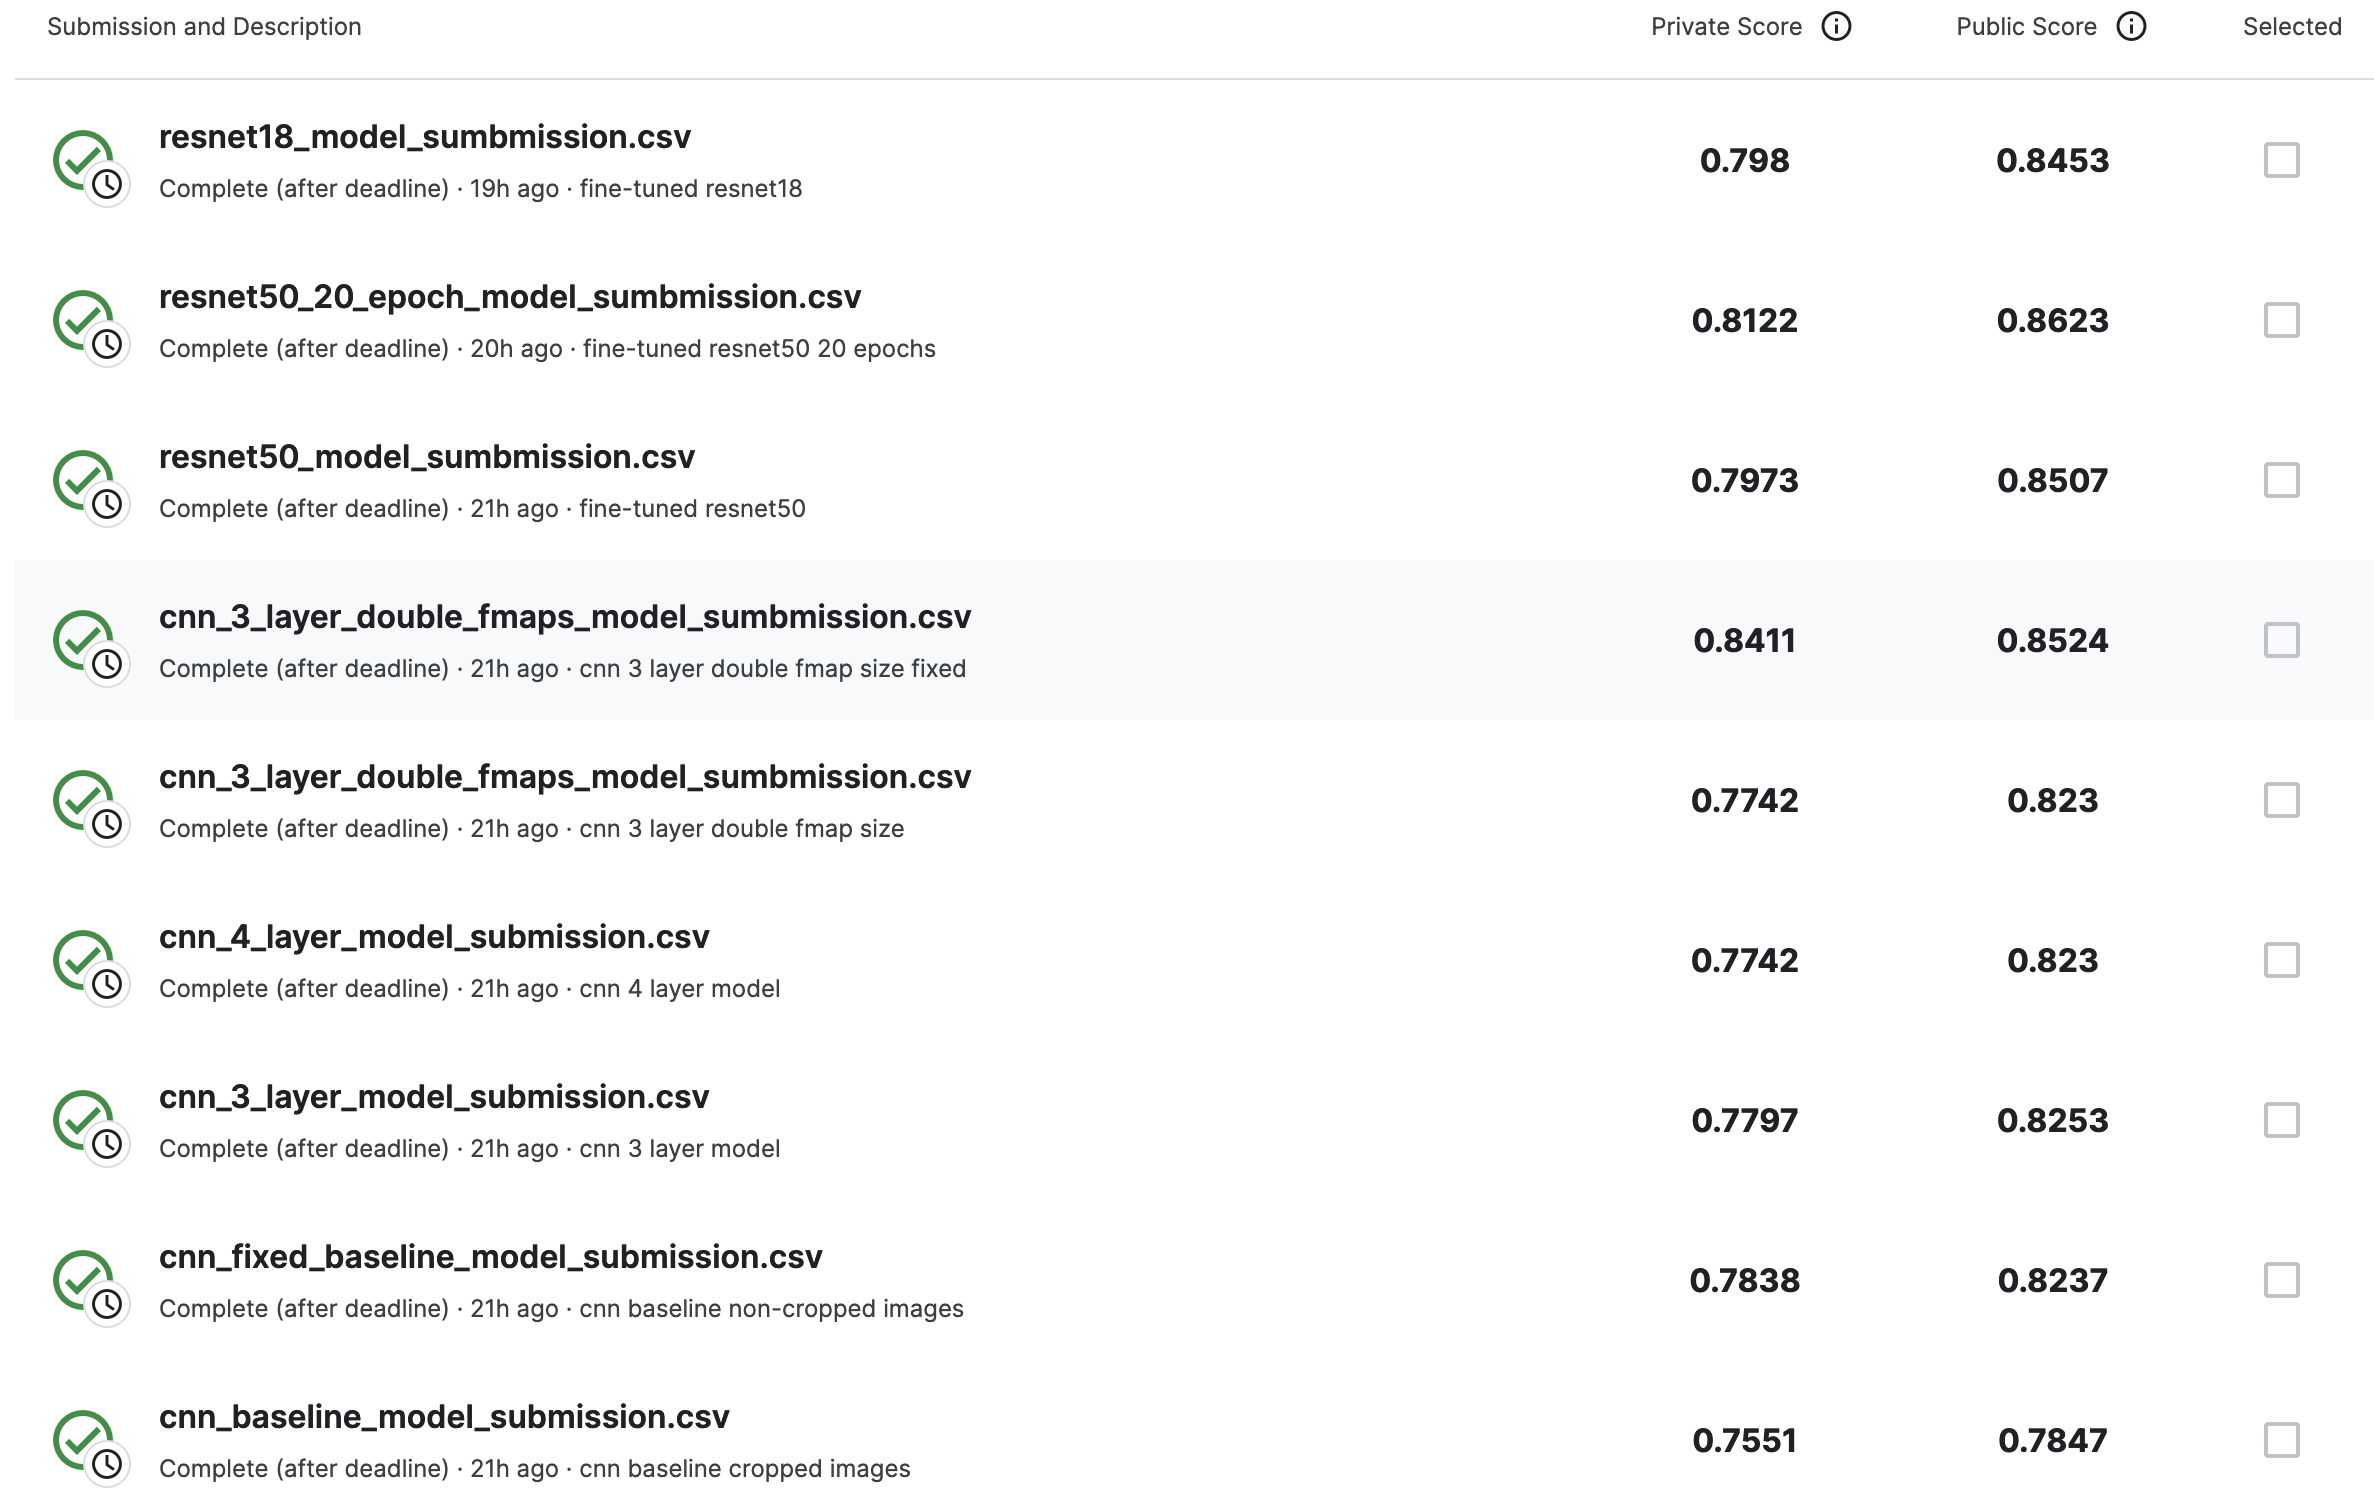

In [157]:
Image(filename = "img/kaggle_submissions.png", width=800, height=400)

The chart below shows the results along with the dev scores.

In [215]:
models = ['cnn baseline - cropped img', 'cnn baseline - full img', 'cnn - 3 layer small', 'cnn - 3 layer large', 
          'cnn - 4 layer', 'resnet50 - 10 epochs', 'resnet50 - 20 epochs']
dev_auc          = [0.818,  0.842,  0.862,  0.891,  0.928,  0.962,  0.964]
public_test_auc  = [0.7847, 0.8237, 0.8253, 0.8524, 0.823,  0.8507, 0.8623]
private_test_auc = [0.7551, 0.7838, 0.7797, 0.8411, 0.7742, 0.7973, 0.8122]
scores_df = pd.DataFrame({'Model': models, 'Dev': dev_auc, 'Public Test': public_test_auc, 'Private Test': private_test_auc}).set_index('Model')

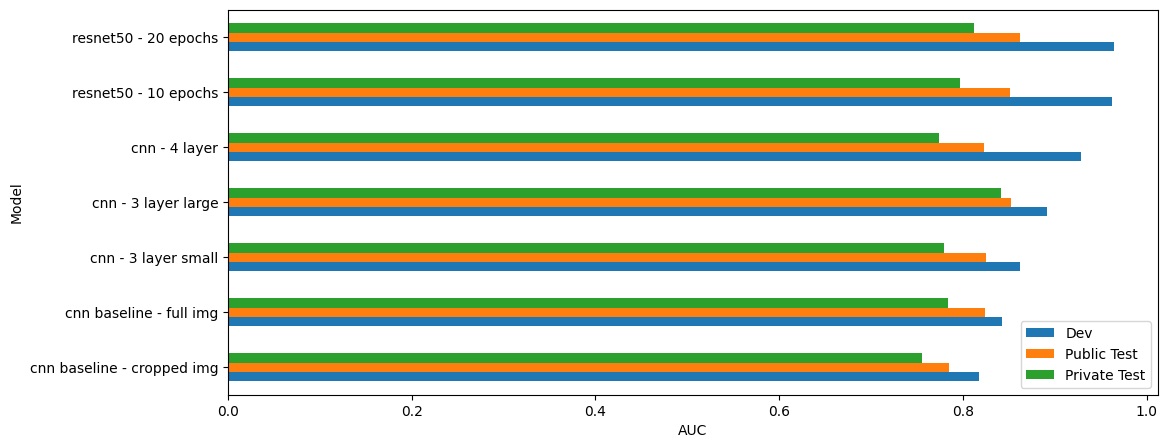

In [217]:
ax = scores_df.plot.barh(rot=0, figsize=(12,5))
ax.set_xlabel("AUC");

The best peforming model on the test set was the fine-tuned ResNet-50 model trained for 20 epochs.  This isn't terribly surprising, as I often encounter cases in which training for longer, even though the loss is barely changing, can result in better performance.  The loss is just ultimately a surrogate for the final metric which often isn't differentiable (for example accuracy or F1 score.)

The 3 layer CNN with a large number of feature maps also performs well, and best on the private dataset. Having a larger model capacity really helps, though of course for training purposes it's easier to debug simpler models.  I don't show it in the code above, but I made sure my models would converge when the dataset was only 100 examples.  I think this is a mandatory step to make sure you can get your model to overtrain.  If you can't get the loss to zero, there's a bug in the code.

I got the biggest gain, however, when I didn't crop the images.

Also, the dev AUC scores in general are much higher than the public and especially the private tests. The private dataset is to prevent participants from tuning their models based on results on the public test set.  I believe my dev set size was too small, and thus not representative enough of the test sets, hence the disparity in scores.

# Discussion and Conclusion

Using a CNN for a school assignment is a reasonable approach, as they are quick to train and work reasonably well on image classification.  

But of course they would never win a Kaggle competition.  Overall, even the best scoring model is nowhwere near the top of the leaderboard.  There are many submissions that get over 97% AUC.  There are things I can do to get a higher score, for example augment the dataset by flipping images.  Or use really complex models.  Or I could do a better job of cleaning the dataset.  I strongly suspect there is more goofy things with the data - blank images or duplicates that should be handled.  I could also re-train the above models with the full training dataset.  But the dev set was only 2.5% of the training set so I suspect this would not make a huge difference.

My hyperparameter procedure was manual as well.  It would be better to use a tool that can automatically do searchs based on all kinds of hyperparameters I did not consider here, for example batch size and optimizers.